<a href="https://colab.research.google.com/github/viper33ashes/DS/blob/main/t20score_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project name: T20 Cricket score predictor
Project Team: Rohit Ramchandani, Milind Gawaskar


Introduction: This code will predict Final score if an innings based on factors such as the batting team, team playing against, city, balls left, wickets left. This is similar to the over by over forecasted score given by espncricinfo and ofthen provides better results

It can also predict final score without any bowl being bowled, by putting values as 120 balls left and 10 wickets remaining. For instace, it predicted 158 runs for India vs Pak at the MCG on 23rd Oct 2022 without any ball bowled.
India scored 160 to win the match!

**Future enhancements**: We will enhance this model to also predict the winner of the match based on additional factors such as toss winner, and previous 3 match encounters.
Also, will tune the curent dataset further by removing abandoned matches results and averaging out the 2nd innnings data that got finished befroe the 20th over




In [111]:
#Project:T20 Score Predictor
#Author: Rohit Ramchandani

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing


In [112]:
file1=pd.read_csv('https://raw.githubusercontent.com/viper33ashes/DS/main/1st%20Innings%20T20.csv')
file2=pd.read_csv('https://raw.githubusercontent.com/viper33ashes/DS/main/2nd%20Innings%20T20.csv')

#Source: https://www.kaggle.com/code/goyalashish/dataset-preparation-t20-international/data



In [113]:
#file2.iloc[100:110]
file1['innings']=1
file2['innings']=2
df=pd.concat([file1,file2]) #Adding both innings
df.tail(5)
df.describe()
#For our dataset and preditions, we will derive and use the follwing features
# batting team
# bowling team
# city
# current_score
# balls left or overs
# wickets_left
# innings
# Final Score (to be predicted!)

,Unnamed: 0,balls,runs,player_out,innings
count,175284.000000,175284.000000,175284.000000,175284.000000,175284.000000
mean,58.912633,9.419129,1.274611,0.053998,1.475343
std,35.075234,5.651009,1.568345,0.226015,0.499393
min,0.000000,0.100000,0.000000,0.000000,1.000000
25%,29.000000,4.500000,0.000000,0.000000,1.000000
50%,58.000000,9.300000,1.000000,0.000000,1.000000
75%,88.000000,14.300000,1.000000,0.000000,2.000000
max,136.000000,19.900000,8.000000,1.000000,2.000000


In [114]:
#Dropping columns not needed
df=df.drop(columns=['Unnamed: 0','venue'])
df.tail(5)

,matchId,balls,runs,tossWinner,battingTeam,bowlingTeam,player_out,city,innings
83315,1795_2,18.1,0,New Zealand,New Zealand,Pakistan,0,Auckland,2
83316,1795_2,18.2,2,New Zealand,New Zealand,Pakistan,0,Auckland,2
83317,1795_2,18.3,0,New Zealand,New Zealand,Pakistan,0,Auckland,2
83318,1795_2,18.4,0,New Zealand,New Zealand,Pakistan,0,Auckland,2
83319,1795_2,18.5,6,New Zealand,New Zealand,Pakistan,0,Auckland,2


In [115]:
#Preprocessing data to have the correct number of deliveries
df['over_Number'] = df['balls'].apply(lambda x:str(x).split(".")[0])
df['ball_no'] = df['balls'].apply(lambda x:str(x).split(".")[1])
df['deliveries'] = df['over_Number'].astype('int')*6 + df['ball_no'].astype('int')
df['delivery_left']=120-df['deliveries']
df['delivery_left']=df['delivery_left'].apply(lambda x: 0 if x<0 else x)

df['wickets_left']=10 - (df.groupby('matchId').cumsum()['player_out'])
df.tail(15)
# balls=df.groupby(by=['matchId','deliveries'],as_index=False).sum()
# #highscorers=df.groupby(by=['Final_Score','battingTeam'], as_index=False).sum()
# balls
df.groupby(['matchId']).max()['deliveries'].sort_values()
#df.drop(df['matchId'] in df.groupby(['matchId']).max()['deliveries'].sort_values()<60, inplace=True)
#QUESTION: How to drop these rows from df?
df.tail(15)


,matchId,balls,runs,tossWinner,battingTeam,bowlingTeam,player_out,city,innings,over_Number,ball_no,deliveries,delivery_left,wickets_left
83305,1795_2,16.5,0,New Zealand,New Zealand,Pakistan,0,Auckland,2,16,5,101,19,5
83306,1795_2,16.6,1,New Zealand,New Zealand,Pakistan,0,Auckland,2,16,6,102,18,5
83307,1795_2,16.7,2,New Zealand,New Zealand,Pakistan,0,Auckland,2,16,7,103,17,5
83308,1795_2,17.1,6,New Zealand,New Zealand,Pakistan,0,Auckland,2,17,1,103,17,5
83309,1795_2,17.2,0,New Zealand,New Zealand,Pakistan,0,Auckland,2,17,2,104,16,5
83310,1795_2,17.3,1,New Zealand,New Zealand,Pakistan,0,Auckland,2,17,3,105,15,5
83311,1795_2,17.4,0,New Zealand,New Zealand,Pakistan,0,Auckland,2,17,4,106,14,5
83312,1795_2,17.5,6,New Zealand,New Zealand,Pakistan,0,Auckland,2,17,5,107,13,5
83313,1795_2,17.6,1,New Zealand,New Zealand,Pakistan,0,Auckland,2,17,6,108,12,5
83314,1795_2,17.7,1,New Zealand,New Zealand,Pakistan,0,Auckland,2,17,7,109,11,5


In [116]:
#Calculate current and  Final score
finalScore=df.groupby('matchId').sum()['runs']
df['current_score']=df.groupby('matchId').cumsum()['runs']
print(finalScore)
#finalScore.describe()
len(finalScore)

matchId
1000_1    133
1000_2    136
1001_1    191
1001_2    164
1004_1    126
         ... 
998_2     168
99_1      147
99_2      124
9_1       202
9_2       127
Name: runs, Length: 1511, dtype: int64


1511

In [117]:
#Merging Final Score onto the main data frame
df=df.merge(finalScore,on='matchId') 
df=df.rename(columns={'runs_y': 'Final_Score'})
len(df['Final_Score'])

df=df[df['Final_Score']>75]
df

,matchId,balls,runs_x,tossWinner,battingTeam,bowlingTeam,player_out,city,innings,over_Number,ball_no,deliveries,delivery_left,wickets_left,current_score,Final_Score
0,5_1,0.1,0,India,West Indies,India,0,Lauderhill,1,0,1,1,119,10,0,95
1,5_1,0.2,0,India,West Indies,India,1,Lauderhill,1,0,2,2,118,9,0,95
2,5_1,0.3,0,India,West Indies,India,0,Lauderhill,1,0,3,3,117,9,0,95
3,5_1,0.4,1,India,West Indies,India,0,Lauderhill,1,0,4,4,116,9,1,95
4,5_1,0.5,0,India,West Indies,India,0,Lauderhill,1,0,5,5,115,9,1,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175279,1795_2,18.1,0,New Zealand,New Zealand,Pakistan,0,Auckland,2,18,1,109,11,5,148,156
175280,1795_2,18.2,2,New Zealand,New Zealand,Pakistan,0,Auckland,2,18,2,110,10,5,150,156
175281,1795_2,18.3,0,New Zealand,New Zealand,Pakistan,0,Auckland,2,18,3,111,9,5,150,156
175282,1795_2,18.4,0,New Zealand,New Zealand,Pakistan,0,Auckland,2,18,4,112,8,5,150,156


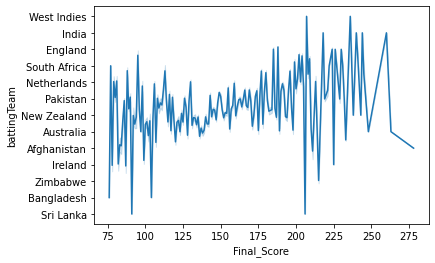

In [118]:
#Plot trial
sns.lineplot(x=df['Final_Score'],y=df['battingTeam'],data=df)

In [119]:
import matplotlib.pyplot as plot
highscorers=df[['matchId','battingTeam','bowlingTeam','balls','current_score','Final_Score']]
highscorers=highscorers.groupby(['matchId']).max()
highscorers=highscorers.sort_values(by=['Final_Score'],ascending=False)
highscorers.head(20)
# highscorers=df.groupby(by=['Final_Score','battingTeam'], as_index=False).sum()
# highscorers[(highscorers['Final_Score']>200)]
#Question: how to plot number of times each team has scored over 200?


,battingTeam,bowlingTeam,balls,current_score,Final_Score
matchId,,,,,
917_1,Afghanistan,Ireland,19.6,278,278
1633_1,Australia,Sri Lanka,19.6,263,263
1173_1,India,Sri Lanka,19.6,260,260
1463_1,Australia,England,19.6,248,248
1699_1,West Indies,India,19.7,245,245
84_2,Australia,New Zealand,18.6,245,245
1699_2,India,West Indies,19.6,244,244
750_1,New Zealand,West Indies,19.6,243,243
84_1,New Zealand,Australia,19.8,243,243


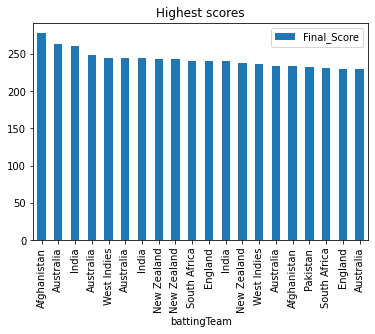

In [120]:


highscorers[:20].plot.bar(x='battingTeam',y='Final_Score', title='Highest scores')
plot.show(block=True)

In [121]:
highscorers[(highscorers['Final_Score']>200) & (highscorers['battingTeam']=='India')].count()

battingTeam      18
bowlingTeam      18
balls            18
current_score    18
Final_Score      18
dtype: int64

Matches in SYdney so far:       city  total_matches
97  Sydney             25
             city  total_matches
29        Colombo             83
40          Dubai             80
72         Mirpur             57
57   Johannesburg             56
52         Harare             56
0       Abu Dhabi             48
5        Auckland             48
19      Cape Town             42
68         London             42
36          Dhaka             35
7        Barbados             34
81      Pallekele             32
105    Wellington             29
43         Durban             26
91        Sharjah             26
97         Sydney             25
22      Centurion             24
95       St Lucia             24
51       Hamilton             24
79     Nottingham             24


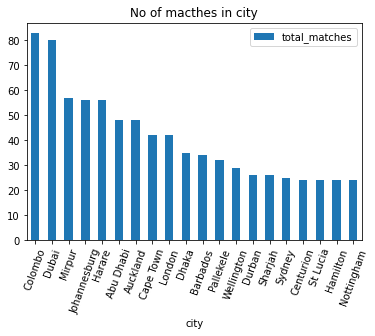

In [122]:
#match count per stadium
match_venue=df.groupby(by=['matchId','city'], as_index=False).sum()

match_count_with_venue=match_venue.groupby(by='city',as_index=False).count()
match_count_with_venue = match_count_with_venue.rename(columns={'matchId': 'total_matches'})
match_count_with_venue=match_count_with_venue[['city','total_matches']]

syd_count=match_count_with_venue[match_count_with_venue['city']=='Sydney']
print('Matches in SYdney so far:',syd_count)
match_count_with_venue=match_count_with_venue.sort_values(by=['total_matches'],ascending='')
print(match_count_with_venue[:20])
match_count_with_venue[:20].plot.bar(x='city',y='total_matches',rot=70, title='No of macthes in city')
#sns.lineplot(x=match_count_with_venue['city'],y=match_count_with_venue['total_matches'],data=match_count_with_venue[:10])


In [123]:
#For our dataset and preditions, we will use only some features
# batting team
# bowling team
# city
# current_score
# balls left or overs
# wickets_left
# innings
features=['battingTeam','bowlingTeam','city','current_score','delivery_left','wickets_left','innings']
data=df[features]
print(len(data))
data.describe()

score=df[['Final_Score']]
print(len(score))
score

172388
172388


,Final_Score
0,95
1,95
2,95
3,95
4,95
...,...
175279,156
175280,156
175281,156
175282,156


In [124]:
#TRAIN TEST SPLIT
data_train,data_test,score_train,score_test=train_test_split(data,score,test_size=0.10,random_state=0)

print(data_train.head(5))
print(data_test.head(5))
print(score_train.head(5))
print(score_test.head(5))

data_test2=data_test.copy()
#data_test[data_test['battingTeam']=='Afghanistan']



        battingTeam   bowlingTeam          city  current_score  delivery_left  \
149813      England         India     Ahmedabad            163              5   
161883  New Zealand  South Africa  Johannesburg              2            114   
57987     Sri Lanka      Zimbabwe    Hambantota            150             11   
100455  West Indies      Pakistan    Providence             68             52   
164267   Bangladesh   West Indies        Mirpur             90             13   

        wickets_left  innings  
149813             3        2  
161883            10        2  
57987              7        1  
100455             8        2  
164267             2        2  
        battingTeam  bowlingTeam        city  current_score  delivery_left  \
57705         India  New Zealand  Wellington             94             40   
121178    Sri Lanka  New Zealand  Lauderhill             56             64   
141464  New Zealand   Bangladesh      Napier             43             85   
98569    

In [125]:
#need to encode string data to float, otherwise model fit fails with error 'could not convert string to float:'
def encoded_df(edf):
  #print(edf)
  number = preprocessing.LabelEncoder()
  for column_name in edf.columns:
      if edf[column_name].dtype == object:
          #print(column_name)  
          edf[column_name] = number.fit_transform(edf[column_name])
      else:
          pass
  return edf




In [126]:
#Encoding the datat sets
t20model=LinearRegression()
data_train=encoded_df(data_train)
score_train=encoded_df(score_train)
data_test=encoded_df(data_test)
#Applying Linear Regression
t20model.fit(data_train,score_train)

score_predict=t20model.predict(data_test)



In [127]:
#Aplying Decision Tree regression model
t20model2=DecisionTreeRegressor()
t20model2.fit(data_train,score_train)
score_predict2=t20model2.predict(data_test)
print(t20model2)


DecisionTreeRegressor()


In [128]:
print(score_test.head(20))
print('Predicted Score by Linear Reg:')
print(score_predict)
print('Predicted Score by Decision Regressor:')
print(score_predict2)

        Final_Score
57705           149
121178           82
141464          143
98569           169
87396           167
14365           201
165349          148
169290          114
163402          160
87691           163
50477           141
97559           181
132517          124
104543          151
168791          128
58650           138
2869            156
114472          105
128089          165
78368           191
Predicted Score by Linear Reg:
[[150.36301463]
 [134.35768295]
 [143.89501473]
 ...
 [138.88759113]
 [148.70126746]
 [172.20376034]]
Predicted Score by Decision Regressor:
[163.  82. 143. ... 140. 176. 118.]


In [129]:
#calculate error
from sklearn.metrics import mean_absolute_error
print('MAE from regression')
mae = mean_absolute_error(score_test, score_predict)
print(mae)
print('MAE from decision')
mae2 = mean_absolute_error(score_test, score_predict2)
print(mae2)

MAE from regression
16.878608906774055
MAE from decision
3.3552603592629118


In [130]:

#caluclate own prediction for Ind vs Pak at MCG on 23rd
#features=['battingTeam','bowlingTeam','city','current_score','delivery_left','wickets_left','innings']
battingTeam='India'
bowlingTeam='Pakistan'
city='Melbourne'
current_score=0
delivery_left=120
wickets_left=10
innings=1
predict_me=[battingTeam,bowlingTeam,city,current_score,delivery_left,wickets_left,innings]
print(predict_me)


print(type(predict_me))

#Uncomment below for adding new rows
data_test2.loc[len(data_test2)]=predict_me 
data_test2.tail(40)







['India', 'Pakistan', 'Melbourne', 0, 120, 10, 1]
<class 'list'>


,battingTeam,bowlingTeam,city,current_score,delivery_left,wickets_left,innings
140496,India,Sri Lanka,Mumbai,66,49,8,2
41708,India,England,Durban,67,75,10,1
38988,South Africa,England,Paarl,33,96,9,1
157976,Sri Lanka,Pakistan,King City,111,29,6,2
143712,Australia,Pakistan,Dubai,40,83,8,2
122743,Pakistan,England,Leeds,35,96,10,2
172910,India,Australia,Mumbai,74,78,9,2
170380,Pakistan,England,Dubai,147,12,4,2
19804,India,New Zealand,Dubai,87,17,5,1
144409,New Zealand,India,Wellington,69,68,9,2


In [131]:
data_test2=encoded_df(data_test2)
data_test2.tail(4)

,battingTeam,bowlingTeam,city,current_score,delivery_left,wickets_left,innings
107811,2,11,36,101,43,2,2
18080,8,9,19,43,77,9,1
71185,9,2,57,88,61,7,1
17239,4,8,71,0,120,10,1


In [132]:

score_predict=t20model.predict(data_test2.tail(4))
score_predict2=t20model2.predict(data_test2.tail(4))
print('Prediction for: ')
print(data_test2.tail(2))
print('Using Linear Reg:')
print(score_predict)
#print('Using Dec Tree Reg:')
#print(score_predict2)

Prediction for: 
       battingTeam  bowlingTeam  city  current_score  delivery_left  \
71185            9            2    57             88             61   
17239            4            8    71              0            120   

       wickets_left  innings  
71185             7        1  
17239            10        1  
Using Linear Reg:
[[138.88759113]
 [148.70126746]
 [172.20376034]
 [158.7803316 ]]
